# pCO$_{2}$ Taylor Expansion
Conducting a Taylor Expansion of the impacts of DIC, Alk, SST, and SALT on pCO$_{2}$ during a climate variability event in EBUS. This is inspired from Nikki Lovenduski's 2007 and 2015 papers.

----

### Expansion

$ \Delta pCO_{2} = \frac{\partial pCO_{2}}{\partial DIC}\Delta DIC + \frac{\partial pCO_{2}}{\partial ALK}\Delta ALK + \frac{\partial pCO_{2}}{\partial SST}\Delta SST + \frac{\partial pCO_{2}}{\partial SALT}\Delta SALT $

### Sensitivity Terms

$ 	\frac{\partial pCO_{2}}{\partial SST} \approx 0.0423^{o}C^{-1}\cdot pCO_{2} $

$ 	\frac{\partial pCO_{2}}{\partial SALT} \approx \frac{pCO_{2}}{SALT} $

$ 	\frac{\partial pCO_{2}}{\partial DIC} = \frac{pCO_{2}}{DIC}\gamma_{DIC} $


$ 	\frac{\partial pCO_{2}}{\partial ALK} = \frac{pCO_{2}}{ALK}\gamma_{ALK} $


### Buffer Factors
$ \gamma_{DIC} = \frac{3\cdot ALK\cdot DIC - 2DIC^{2}}{(2DIC - ALK)(ALK - DIC)} $

$ \gamma_{ALK} = - \frac{ALK^{2}}{(2DIC - ALK)(ALK-DIC)} $


In [124]:
import glob
import numpy as np
from numpy import mean
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [198]:
ens = ['001', '002', '009', '010', '011',
       '012', '013', '014', '015', '016',
       '017', '018', '019', '020', '021',
       '022', '023', '024', '025', '026',
       '027', '028', '029', '030', '031',
       '032', '033', '034', '035', '101',
       '102', '103', '104', '105']
colors = {
    'CalCS': '#80b1d3',
    'HumCS': '#fb8072',
    'CanCS': '#fdb462',
    'BenCS': '#bc80bd'
}

# Functions

In [2]:
def load_forced_signal(VAR, EBU):
    fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/' + VAR + '/' + EBU + '/filtered_output/'
    fileName = EBU.lower() + '-' + VAR + '-forced-signal-AW-chavez-800km.nc'
    ds = xr.open_dataset(fileDir + fileName)
    data = ds[VAR + '_AW'].values
    return data

# Determine Sensitivity Terms

In [ ]:
EBUs = ['CalCS', 'HumCS', 'CanCS', 'BenCS']
buffers = dict()
sensitivities = dict()
for idx in EBUs:
    pCO2 = load_forced_signal('pCO2SURF', idx)
    DIC = load_forced_signal('DIC', idx)
    SALT = load_forced_signal('SALT', idx)
    ALK = load_forced_signal('ALK', idx)
    SST = load_forced_signal('SST', idx)
    SALT = load_forced_signal('SALT', idx)
    # Compute buffer factors for DIC/ALK.
    buffer_factor = dict()
    buffer_factor['ALK'] = -mean(ALK)**2 / ((2 * mean(DIC) - mean(ALK)) * (mean(ALK) - mean(DIC)))
    buffer_factor['DIC'] = (3*mean(ALK)*mean(DIC) - 2*mean(DIC)**2) / \
                           ((2 * mean(DIC) - mean(ALK)) * (mean(ALK) - mean(DIC)))
    # Compute sensitivities
    sensitivity = dict()
    sensitivity['SST'] = 0.0423 * mean(pCO2)
    sensitivity['SALT'] = mean(pCO2)/mean(SALT)
    sensitivity['ALK'] = (mean(pCO2)/mean(ALK))*buffer_factor['ALK']
    sensitivity['DIC'] = (mean(pCO2)/mean(DIC))*buffer_factor['DIC']
    # Place in final arrays.
    buffers[idx] = buffer_factor
    sensitivities[idx] = sensitivity

In [ ]:
# Make them Pandas!
buffers = pd.DataFrame(data=buffers)
sensitivities = pd.DataFrame(data=sensitivities)

In [ ]:
# Save for later!
directory = '/glade/u/home/rbrady/projects/EBUS_BGC_Variability/data/processed/all-systems/'
buffers.to_csv(directory + 'pCO2_buffers_all_systems')
sensitivities.to_csv(directory + 'pCO2_sensitivities_all_systems')

# Compute Linear Expansion

In [147]:
def load_correlations(VAR, EBU, smoothed=True):
    fileDir = '/glade/u/home/rbrady/projects/EBUS_BGC_Variability/data/processed/' + \
                EBU.lower() + '/'
    if smoothed == False:
        fileName = 'unsmoothed_' + VAR + '_vs_enso_' + EBU
    else:
        fileName = 'smoothed_' + VAR + '_vs_enso_' + EBU        
    df = pd.DataFrame.from_csv(fileDir + fileName)
    df.index = ens
    return df

In [301]:
def taylor_expansion(EBU):
    pCO2_corr = load_correlations('pCO2SURF', EBU)
    DIC_corr = load_correlations('DIC', EBU)
    ALK_corr = load_correlations('ALK', EBU)
    SST_corr = load_correlations('SST', EBU)
    SALT_corr = load_correlations('SALT', EBU)
    # Just pull out slopes.
    pCO2 = pCO2_corr['Slope']
    DIC = DIC_corr['Slope']
    ALK = ALK_corr['Slope']
    SST = SST_corr['Slope']
    SALT = SALT_corr['Slope']
    # Compute expansion and store as DataFrame.
    terms = dict()
    terms['DIC'] = DIC * sensitivities[EBU]['DIC']
    terms['ALK'] = ALK * sensitivities[EBU]['ALK']
    terms['SST'] = SST * sensitivities[EBU]['SST']
    terms['SALT'] = SALT * sensitivities[EBU]['SALT']
    terms = pd.DataFrame(data=terms)
    terms['Total'] = terms.sum(axis=1)
    # Indicator for visualization/analysis
    # terms['EBUS'] = EBU
    return terms

In [226]:
# Load in sensitivity/buffer results.
fileDir = '/glade/u/home/rbrady/projects/EBUS_BGC_Variability/data/processed/all-systems/'
buffers = pd.DataFrame.from_csv(fileDir + 'pCO2_buffers_all_systems')
sensitivities = pd.DataFrame.from_csv(fileDir + 'pCO2_sensitivities_all_systems')

In [309]:
df_cal = taylor_expansion('CalCS')
df_cal = pd.melt(df_cal)
df_cal['EBUS'] = 'CalCS'
df_hum = taylor_expansion('HumCS')
df_hum = pd.melt(df_hum)
df_hum['EBUS'] = 'HumCS'
frames = [df_cal, df_hum]
taylor_terms = pd.concat(frames)

# Visualize

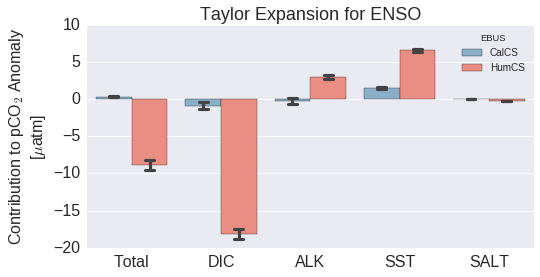

In [327]:
fig = plt.figure(figsize=(8,4))
sns.set_style("darkgrid")
order = list(['Total', 'DIC', 'ALK', 'SST', 'SALT'])
#ax = sns.barplot(x="variable", y="value", data=pd.melt(df_cal), order=order, color=colors[EBU],
#                ci=95, capsize=0.1)
ax = sns.barplot(x="variable", y="value", data=taylor_terms, hue="EBUS", order=order, 
                 palette=[colors['CalCS'], colors['HumCS']], capsize=0.1,
                ci=95)
ax.set_ylabel('Contribution to pCO$_{2}$ Anomaly' + '\n' + '[$\mu$atm]', fontsize=16)
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('Taylor Expansion for ENSO', fontsize=18)

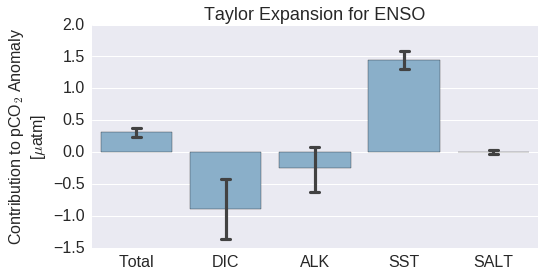

In [329]:
fig = plt.figure(figsize=(8,4))
sns.set_style("darkgrid")
order = list(['Total', 'DIC', 'ALK', 'SST', 'SALT'])
ax = sns.barplot(x="variable", y="value", data=df_cal, order=order, color=colors[EBU],
                ci=95, capsize=0.1)
ax.set_ylabel('Contribution to pCO$_{2}$ Anomaly' + '\n' + '[$\mu$atm]', fontsize=16)
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('Taylor Expansion for ENSO', fontsize=18)